# ForceSMIP Example: Linear Inverse Model

by [Tongtong Xu](https://xutongtong.net/)

#### 1. Introduction
Here we provide an example for estimating the forced signal of the sea surface temperature (`tos`), using a multivariate empirical dynamical approach, the Linear Inverse Model (LIM; [Penland and Sardeshmukh, 1995](https://journals.ametsoc.org/view/journals/clim/8/8/1520-0442_1995_008_1999_togots_2_0_co_2.xml)). The LIM assumes that the time evolution of a climate state can be approximated by the stochastically forced linear dynamical system, where its deterministic operator is derived from the simultaneous and lagged covariances of the climate state. The least damped eigenmode of LIM's operator has been used to extract the forced signal of a climate state, a technique established and applied by several previous studies (e.g., [Penland and Matrosova, 2006](https://doi.org/10.1175/JCLI3951.1); [Solomon and M. Newman, 2012](https://doi.org/10.1038/nclimate1591); [Frankignoul et al, 2017](https://doi.org/10.1175/JCLI-D-17-0009.1); [Xu et al, 2022](https://doi.org/10.1038/s41467-022-34934-x)). Additional information about LIM is also available at [GitHub](https://github.com/Tongtong-Xu-PSL/LIM). 

In the following, relevant functions are introduced step-by-step (section 2). The main script that calls these functions is listed in section 3. In section 4, the notebook is concluded with some questions to be considered.

#### 2. Relevant functions

In [1]:
def ForceSMIP_read(fname,varname):
    # this function reads in the data from netcdf
    # input: fname is a string containing (the path and) the name of the ncfile
    #        varname is a string containing the name of the climate variable to be read, e.g., ""
    # output: a dictionary, containing the 3D climate field, lon & lat in 2D, and time
    
    data = xr.open_dataset(fname)
    
    s = dict()
    s["lon"],s["lat"] = np.meshgrid(data["lon"],data["lat"])
    s[varname] = data[varname].values
    s["mask"] = 1 - 0*s[varname].sum(axis=0)
    s["time"] = data["time"]    
    return s

In [2]:
def ForceSMIP_removeSeas(z,time):
    # this function removes the seasonal mean climatology
    # input: z is the 3D climate field [time, lat, lon], time is the time series (xarray format)
    # output: seasonal mean fields (seas in [season, lat, lon]), and anomalies in the same size as z
    
    monlist = time.dt.month.values
    T, J, I = z.shape

    # get seasonality matrices
    seas = np.zeros((12, J, I))
    for i in range(1, 13):
        loc = monlist == i
        seas[i-1, :, :] = np.mean(z[loc, :, :], axis=0)

    # get anomaly after removing seasonality
    ano = np.zeros_like(z)
    for i in range(1, 13):
        loc = monlist == i
        ano[loc, :, :] = z[loc, :, :] - seas[i-1, :, :]
    return seas,ano

In [3]:
def ForceSMIP_XYT_into_ZT(z,mask):
    # convert 3D array into 2D, such that the climate field is represented in [time, space]
    # input: z is the 3D array of [time, lat, lon], mask is the 2D array of [lat,lon], containing either 1 or nan
    
    T, J, I = z.shape
    z = np.multiply(z,np.tile(mask[np.newaxis,:,:], (T, 1, 1)))
    z = z.reshape(T,J*I)
    idx = np.where(~np.isnan(z[0, :]))[0]
    zout = z[:,idx]
    return zout

def ForceSMIP_ZT_into_XYT(z,mask):
    # convert 2D array back to 3D, such that the climate field is represented in [time, lat, lon]
    # input: z is the 2D array of [time, space], mask is the 2D array of [lat,lon], containing either 1 or nan
    
    J, I = mask.shape
    T, _ = z.shape
    idx = np.where(~np.isnan(mask.reshape(J*I)))[0]
    zout = np.zeros((T,J*I))
    zout[:,idx] = z
    zout = np.multiply(zout.reshape(T,J,I),np.tile(mask[np.newaxis,:,:], (T, 1, 1)))
    return zout

In [4]:
def ForceSMIP_EOF(A):
    # EOF analysis of the climate field, note that the climate field has to be in 2D format [time, space]
    # output: a dictionary, containing EOF in [mode, space], PC in [time, mode], lamb is the portion of explained variance by each PC
    
    norm = np.sqrt(np.mean(np.mean(A**2, axis=0)))
    A = A/norm
    
    U, S, V = np.linalg.svd(A, full_matrices=False)

    s = dict()
    s["EOF"] = V
    s["PC"] = np.dot(A, s["EOF"].T)
    D = S ** 2
    s["D"] = D / np.sum(D)
    s["norm"] = norm
    return s

In [5]:
def ForceSMIP_lim_trend(X,tau0):
    # derive the LIM based trend
    # input: X is 2D field in [mode, time], tau0 is the training lag
    # output: u, the spatial pattern of the least damped mode; alpha, the time series associated with the least damped mode;
    #         X_least_damped is in [mode, time], the trend representation in PC space

    X0 = X[:,:-tau0]
    Xtau = X[:,tau0:]

    C0 = np.dot(X0, X0.T) / (X0.shape[1] - 1)
    Ctau = np.dot(Xtau, X0.T) / (X0.shape[1] - 1)

    # linear operator
    G = np.dot(Ctau,np.linalg.pinv(C0))
    D,U = np.linalg.eig(G)
    D = np.log(D)/tau0
    V = np.linalg.inv(U).T

    # sort modes
    loc = np.argsort(-np.real(D))
    sigma = -1 / np.real(D[loc])
    UU = U[:, loc]
    VV = V[:, loc]

    # identify the least damped mode
    u = UU[:, 0]
    v = VV[:, 0]
    alpha = np.dot(v, X)

    X_least_damped = np.real(np.outer(u, alpha))
    return u, alpha, X_least_damped

In [6]:
def ForceSMIP_plot_map(z,data):
    # this function plots the global spatial map
    # z is the map to be plotted, data is the dictionary containing (at least) lon, lat in 2D,
    # as well as the mask; size of z, lon, lat, mask must match
    level = np.nanmax(z)
    
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))

    im = ax.contourf(data["lon"], data["lat"], np.multiply(z,data["mask"]), levels=np.linspace(-level, level, 11),
                transform=ccrs.PlateCarree(),
                cmap=plt.cm.RdBu_r,extend='both')
    ax.coastlines()
    ax.set_global()
    ax.set_extent([np.min(data["lon"]),np.max(data["lon"]),np.min(data["lat"]),np.max(data["lat"])],crs=ccrs.PlateCarree())
    fig.colorbar(im)

In [7]:
def ForceSMIP_plot_index(field,trend,time):
    # this function plots the time series
    # field is the 2D climate field in [time, space]
    # trend is the 2D trend estimate in [time, space]
    # time is in (xarray format)
    
    field = data2D

    f = np.mean(field, axis=1)
    t = np.mean(trend, axis=1)

    plt.figure(figsize=(7, 4.5))  
    plt.plot(data['time'], f, linewidth=1, color=[0.6, 0.6, 0.6])
    plt.plot(data['time'], t, linewidth=3)
    plt.legend(['Global mean', 'Trend'], loc='upper left')
    plt.tight_layout()

#### 3. Main script

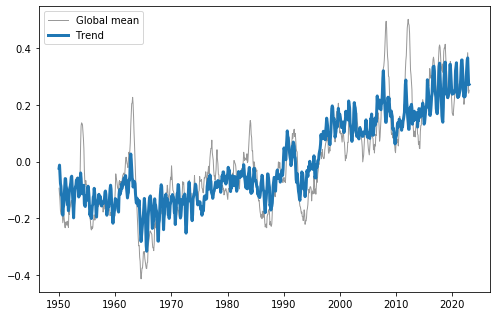

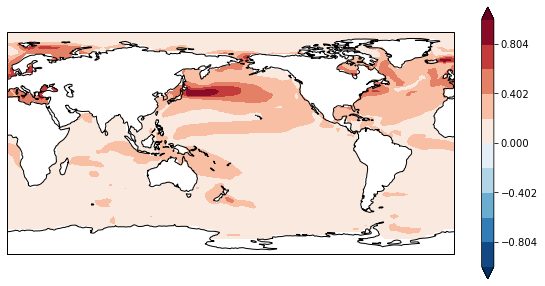

In [8]:
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# -----To be Change-----
fname = "tos_mon_1H.195001-202212.nc" # place the sample dataset in the same path as this notebook
varname = "tos" # climate field of interest
pcnum = 8 # EOF truncation relevant to LIM (how many EOFs are kept?)
# ----------------------

# READ data
data = ForceSMIP_read(fname,varname)

# REMOVE SEASONAL MEAN
data["seas"],data["ano"] = ForceSMIP_removeSeas(data[varname],data["time"])

# EOF ANALYSIS
data2D = ForceSMIP_XYT_into_ZT(data["ano"],data["mask"])
pca = ForceSMIP_EOF(data2D)

# LIM based trend estimate
# Note: for multiple variables, we typically construct a state vector X that consists of the leading 
# PCs of all variables.
X = pca["PC"][:,0:pcnum].T # transpose into a format of [mode, time]
tau0 = 1 # training lag in LIM
u, alpha, X_least_damped = ForceSMIP_lim_trend(X,tau0)
trend = X_least_damped.T @ pca["EOF"][0:pcnum,:]*pca["norm"]

# PLOT result
# plot global mean time series against the globally averaged trend
ForceSMIP_plot_index(data2D,trend,data["time"])
# plot the standard deviation of the trend to have a raw understanding of the magnitude
tmp = np.std(trend,axis=0); tmp = tmp[np.newaxis,:]
trendsd = ForceSMIP_ZT_into_XYT(tmp,data["mask"])
ForceSMIP_plot_map(trendsd[0,:,:],data)

#### 4. Conclusion

This notebook serves as an example of how LIM approach works in terms of identifying the forced signal. However, there are many other things to consider in LIM, and in the actual scale of the scientific question. For example, we at least need to understand the linear dynamical system that has been constructed. Is it a numerically stable linear system? Can the system reasonably reproduce the lag-covariance statistics of the climate states over lags considerably longer than the training lag, also known as LIM's tau test (see [Penland and Sardeshmukh, 1995](https://journals.ametsoc.org/view/journals/clim/8/8/1520-0442_1995_008_1999_togots_2_0_co_2.xml) or supplementary of [Xu et al, 2021](https://doi.org/10.1029/2020GL090661))? Is the EOF truncation the optimized option, i.e., whether the system is overfitted such that it fails to represent the dynamical system of interest? How sensitive is this approach to the length of the data record? Can we improve upon the LIM approach (e.g., [Solomon and M. Newman, 2012](https://doi.org/10.1038/nclimate1591); [Frankignoul et al, 2017](https://doi.org/10.1175/JCLI-D-17-0009.1); [Wills et al, 2020](https://doi.org/10.1175/JCLI-D-19-0855.1)), and under what scenarios is LIM and LIM-based improvment useful? 

The hackathon provides ensemble realizations for training/validation of the methodology. Can we make use of them to help improve the forced estimate? How to modify the notebook to incoporate the forced estimate identification for all variables of interest? All of the aforementioned considerations are not explored and investigated in this notebook, as this is meant to be a simple coding example. See the LIMopt notebook for a more extensive and comprehensive example.

Thus, please proceed with caution when using this notebook. Feel free to reach out for any questions and suggestions!